In [191]:
%matplotlib inline
import sys
import glob
import os
import random
import json
import pickle
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

from astropy.table import Table
import rubin_sim.maf.db as db
from rubin_sim import maf
from rubin_sim.maf.utils import m52snr
import rubin_sim.maf.metrics as metrics
import rubin_sim.maf.plots as plots

import rubin_sim.maf.slicers as slicers
import rubin_sim.maf.metric_bundles as metric_bundles
from astropy.cosmology import z_at_value
from rubin_sim.maf.metrics import BaseMetric
from rubin_sim.maf.slicers import UserPointsSlicer
from rubin_sim.maf.metric_bundles import MetricBundle, MetricBundleGroup
from rubin_sim.maf.db import ResultsDb
import rubin_sim.maf.utils as maf_utils
import rubin_sim.maf.metrics as metrics
from rubin_sim.maf.plots import HealpixSkyMap
import rubin_sim.maf.plots as plots
#from local_opsdb_patch import OpsimDatabase
from rubin_sim.maf.metrics import SumMetric
#from rubin_sim.utils import equatorialFromGalactic, hpid2RaDec, _healbin, healbin
from astropy.coordinates import Galactic, ICRS
import astropy.units as u
import healpy as hp
import importlib
from rubin_sim.phot_utils import DustValues
# Add current script's directory to sys.path
sys.path.append("/Users/andradenebula/Documents/Research/Transient_Metrics/Multi_Transient_Metrics_Hub")
from shared_utils import inject_uniform_healpix
#from local_opsdb_patch import OpsimDatabase #local

dust_model = DustValues()
#from rubin_sim.utils import getPackageDir
from importlib import resources

def getPackageDir(pkg_name):
    try:
        return resources.files(pkg_name).parent
    except Exception as e:
        raise RuntimeError(f"Could not find package {pkg_name}: {e}")
        
import sqlite3
from pathlib import Path


        

In [214]:
# Clear and reload module
if "local_kne_metrics" in sys.modules:
    del sys.modules["local_kne_metrics"]
import local_kne_metrics
importlib.reload(local_kne_metrics)
from local_kne_metrics import (
    KNePopMetric,
    KNeDetectMetric,
    KNeZTFRestSimpleMetric,
    KNeZTFRestSimpleRedMetric,
    KNeZTFRestSimpleBlueMetric,
    KNeMultiColorDetectMetric,
    KNeRedColorDetectMetric,
    KNeBlueColorDetectMetric,
    generateKNPopSlicer
)
# Confirm path
print(local_kne_metrics.__file__)
# Clear the module from cache
if "shared_utils" in sys.modules:
    del sys.modules["shared_utils"]
import shared_utils 
importlib.reload(shared_utils)


/Users/andradenebula/Documents/Research/Transient_Metrics/Multi_Transient_Metrics_Hub/KNe/local_kne_metrics.py


<module 'shared_utils' from '/Users/andradenebula/Documents/Research/Transient_Metrics/Multi_Transient_Metrics_Hub/shared_utils.py'>

In [ ]:
# -------- CONFIG --------
cadences = ['four_roll_v4.3.1_10yrs', 'baseline_v4.3.1_10yrs']
outdir_root = "KNe_output"
kne_templates_file = "kne_templates_used.pkl"
db_dir = "../"
dmin, dmax = 10, 1200
t_start = 1
t_end = 3652
n_events = 500000
n_files = 100

os.makedirs(outdir_root, exist_ok=True)

# -------- POPULATION SETUP --------
if os.path.exists(kne_templates_file):
    print(f"Loading KNe population from {kne_templates_file}")
    slicer = generateKNPopSlicer(n_events=n_events, n_files=n_files, save_to=None)
else:
    print("No saved KNe template file found — generating.")
    slicer = generateKNPopSlicer(n_events=n_events, n_files=n_files, save_to=kne_templates_file)

n_events = len(slicer.slice_points['distance'])
ax1 = DustValues().ax1

# -------- METRIC LOOP --------
for cadence in cadences:
    print(f"\n--- Running {cadence} ---")
    opsdb_path = os.path.join(db_dir, f"{cadence}.db")
    outDir = os.path.join(outdir_root, f"Metric_temp_{cadence}")
    os.makedirs(outDir, exist_ok=True)

    opsdb = OpsimDatabase(opsdb_path)

    # Map metric names to their custom classes
    metric_classes = OrderedDict([
        ("KNeDetect", KNeDetectMetric),
        ("KNeZTFRestSimple", KNeZTFRestSimpleMetric),
        ("KNeZTFRestSimpleRed", KNeZTFRestSimpleRedMetric),
        ("KNeZTFRestSimpleBlue", KNeZTFRestSimpleBlueMetric),
        ("KNeMultiColorDetect", KNeMultiColorDetectMetric),
        ("KNeRedColorDetect", KNeRedColorDetectMetric),
        ("KNeBlueColorDetect", KNeBlueColorDetectMetric)
    ])

    metrics_dict = OrderedDict()
    for name, cls in metric_classes.items():
        metrics_dict[name] = MetricBundle(
            cls(), slicer,
            constraint='',
            summary_metrics=[SumMetric()],
            plot_funcs=[]
        )

    group = MetricBundleGroup(metrics_dict, opsdb_path, outDir)
    group.run_all()

    for mname in metrics_dict:
        mv = metrics_dict[mname].metric_values
        n_valid = np.sum(~mv.mask)
        print(f"{mname}: {n_valid}/{n_events} valid detections")

    # ---- SAVE TO CSV ----
    summary_file = os.path.join(outDir, f"kne_detection_summary_{cadence}.csv")
    with open(summary_file, "w") as out:
        out.write("sid," + ",".join(metric_classes.keys()) + "\n")
        for i in range(n_events):
            row_vals = []
            for mname in metric_classes:
                mv = metrics_dict[mname].metric_values
                raw = mv[i]
                if mv.mask[i] or np.isnan(raw):
                    val = -1
                else:
                    val = int(raw)
                row_vals.append(str(val))
            out.write(f"{i}," + ",".join(row_vals) + "\n")


    # ---- SCATTER PLOT OF MAG VS RA/DEC ----
    for mname in metrics_dict:
        mv = metrics_dict[mname].metric_values
        detected = np.logical_and(mv == 1, ~mv.mask)

        plt.figure(figsize=(6, 4))
        plt.scatter(np.degrees(slicer.slice_points['ra'][detected]),
                    np.degrees(slicer.slice_points['dec'][detected]),
                    s=3, label='Detected', color='crimson', alpha=0.7)
        plt.xlabel("RA [deg]")
        plt.ylabel("Dec [deg]")
        plt.title(f"{cadence} – {mname} – Sky Positions")
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(os.path.join(outDir, f"{mname}_radec_scatter.png"))
        plt.close()

    # ---- HEALPIX EFFICIENCY MAP ----
    nside = 64
    npix = hp.nside2npix(nside)
    theta = 0.5 * np.pi - slicer.slice_points['dec']
    phi = slicer.slice_points['ra']
    pix_inds = hp.ang2pix(nside, theta, phi)
    
    for mname in metrics_dict:
        mv = metrics_dict[mname].metric_values
        unique_vals = np.unique(mv[~mv.mask])
        print(f"Unique values in {mname}: {unique_vals}")
        detected = np.logical_and(mv == 1, ~mv.mask)
        n_detected = np.sum(detected)
        print(f"{mname}: {n_detected}/{n_events} detected")


        for i, pix in enumerate(pix_inds):
            injected_map[pix] += 1
            if detected[i]:
                detected_map[pix] += 1

        eff_map = np.full(npix, hp.UNSEEN)
        mask = injected_map > 0
        eff_map[mask] = detected_map[mask] / injected_map[mask]

        hp.mollview(eff_map, title=f"{cadence} – {mname} Efficiency", unit='Efficiency', cmap='viridis')
        hp.graticule()
        plt.savefig(os.path.join(outDir, f"{mname}_healpix_efficiency.png"))
        plt.show()


No saved KNe template file found — generating.
Saved selected KNe templates to kne_templates_used.pkl

--- Running four_roll_v4.3.1_10yrs ---


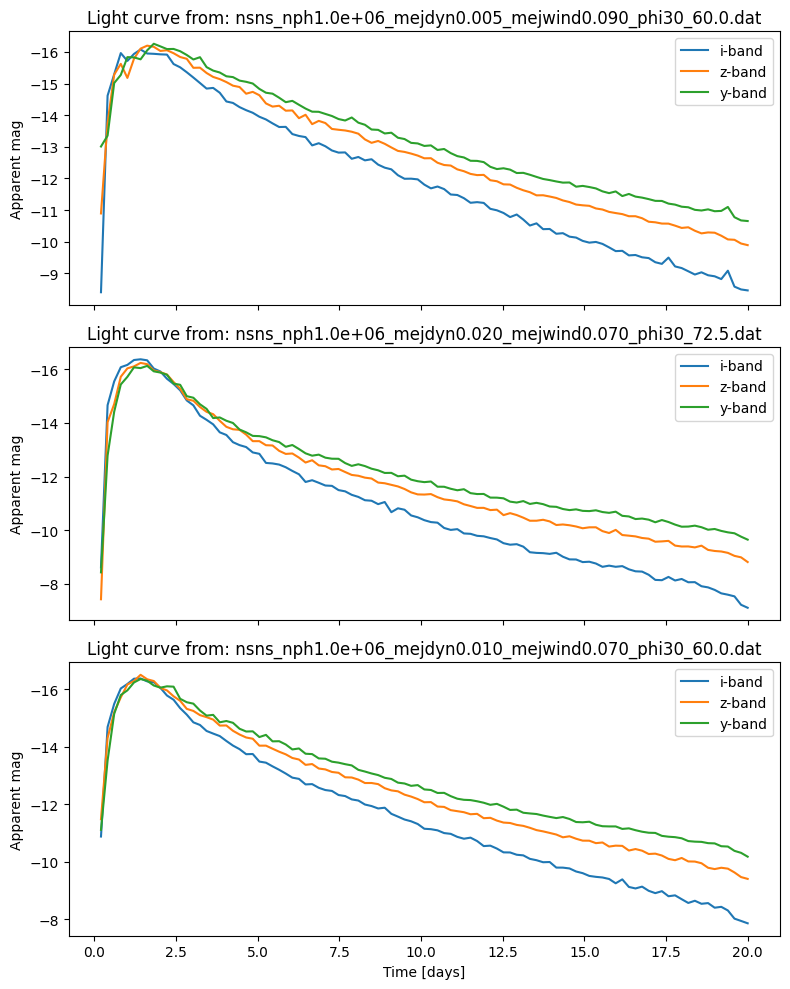

In [199]:
# Re-import libraries due to kernel reset
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os

# Load light curve template metadata
template_file = "kne_templates_used.pkl"
with open(template_file, "rb") as f:
    templates = pickle.load(f)

# Load and parse 3 red-peaking templates from the selected ones
sample_files = [entry["filename"] for entry in templates[:3]]

# Filters and column indices for ugrizy
filters = ['u', 'g', 'r', 'i', 'z', 'y']
col_indices = dict(zip(filters, range(1, 7)))

# Plot each filter's light curve for each selected file
fig, axs = plt.subplots(len(sample_files), 1, figsize=(8, 10), sharex=True)

for i, file in enumerate(sample_files):
    try:
        data = np.loadtxt(file)
        time = data[:, 0]
        for f in ['i', 'z', 'y']:
            mag = data[:, col_indices[f]]
            axs[i].plot(time, mag, label=f'{f}-band')
        axs[i].invert_yaxis()
        axs[i].set_ylabel("Apparent mag")
        axs[i].legend()
        axs[i].set_title(f"Light curve from: {os.path.basename(file)}")
    except Exception as e:
        axs[i].set_title(f"Error reading {file}: {e}")

axs[-1].set_xlabel("Time [days]")
plt.tight_layout()
plt.show()
